# Taylor Diagrams to compare ERA5 data with Metis199, 639, and 1279

Uses Y. Copin's Taylor Diagram python script (https://gist.github.com/ycopin/3342888) (`taylorDiagram.py`) to create Taylor Diagrams to compare the circulation regime composites of ERA5 with Metis199, 639 for NDJFM, and Metis199, 639, 1279 for ND. Set k=4,5 clusters.

For a tutorial and several examples, see `Taylor_tutorial.ipynb`.

Taylor Diagram: plots model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).

Here, ERA5 is the reference, and the Metis data are the samples.

## Constants

In [46]:
# Number of clusters (4 or 5)
cluster_k=5

# Variable to compare (z500 or u250)
variable = 'z500'

# Months to compare (NDJFM or ND)
era_months = 'ND'
metis_months = 'ND'

# Comparing ERA5 with itself?
era5_comp = False

# Grid of the data (N32 or N128)
data_grid = 'N32'

#Set regime names
if cluster_k == 5:
    cluster_names = ['Arctic Low', 'Pacific Wavetrain', 'Pacific Trough', 'Arctic High', 'Alaskan Ridge']
    print(cluster_k)
    if era_months == 'ND':
        cluster_names = ['Alaskan Ridge', 'Arctic Low','Pacific Trough', 'Pacific Wavetrain','Arctic High']
elif cluster_k == 4:
    cluster_names = ['Arctic Low','Pacific Trough','Alaskan Ridge', 'Pacific Wavetrain']
    if era_months == 'ND':
        cluster_names = ['Pacific Wavetrain', 'Alaskan Ridge', 'Arctic Low', 'Pacific Trough']
    print(cluster_k)
else:
    cluster_names = []
    
print(cluster_names)

5
['Alaskan Ridge', 'Arctic Low', 'Pacific Trough', 'Pacific Wavetrain', 'Arctic High']


## Pattern Correlation Method

In [47]:
def PattCorr(ds_met, ds_comp, ds_coslat):    
    
    #Numerator
    ds_num = ds_met * ds_comp * ds_coslat
    ds_num_sum = ds_num.sum(dim=['lat','lon'])

    #Denominator
    ds_met_sq = ds_met**2
    ds_met_sq_cos = ds_met_sq * ds_coslat
    ds_met_sum = ds_met_sq_cos.sum(dim=['lat','lon'])
    ds_comp_sq = ds_comp**2
    ds_comp_sq_cos = ds_comp_sq * ds_coslat
    ds_comp_sum = ds_comp_sq_cos.sum(dim=['lat','lon'])
    ds_den = ds_met_sum * ds_comp_sum
    ds_den_sqrt = ds_den**(1/2)

    #Correlation
    ds_corr = ds_num_sum/ds_den_sqrt
    
    return(ds_corr)

## Imports

In [48]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
import matplotlib.lines as mlines


# Import Taylor Diagram code from 'taylorDiagram.py'
from taylorDiagram import TaylorDiagram

## Files

In [49]:
#Path
path = '/glade/work/mkorendy/metisregimes/'

if data_grid == 'N32':

    #ERA5 file
    if era_months != 'ND':
        f_era = path + 'era5.z500_u250_pna_' + era_months + '_lpfilter_twicedaily_10days.1986-2015.comp_k' + str(cluster_k) + '.nc'
    else:
        f_era = path + 'era5.z500_u250_pna_' + era_months + '_lpfilter_twicedaily_10days.1986-2015.totcomp_k' + str(cluster_k) + '.nc'

    #Metis data
    
    if metis_months == 'ND':
        f_metis199 = path + 'metis.z500_u250_pna_ND_lpfilter_twicedaily_10days.1986-2015.totcomp_k' + str(cluster_k) + '.nc'
        f_metis639 = path + 'tco639/metis.z500_u250_pna_ND_lpfilter_twicedaily_10days.1986-2015.totcomp_k' + str(cluster_k) + '.nc'
        f_metis1279 = path + 'tco1279/metis.z500_u250_pna_ND_lpfilter_twicedaily_10days.1986-2015.totcomp_k' + str(cluster_k) + '.nc'
    else:
        f_metis199 = path + 'metis.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.totcomp_k' + str(cluster_k) + '.nc'
        f_metis639 = path + 'tco639/metis.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.totcomp_k' + str(cluster_k) + '.nc'
        
    f_pic = 'taylor.z500_pna_' + metis_months + '.1986-2015.k' + str(cluster_k) + '.' + data_grid

In [50]:
print(f_era, f_metis199, f_metis639,f_pic)

/glade/work/mkorendy/metisregimes/era5.z500_u250_pna_ND_lpfilter_twicedaily_10days.1986-2015.totcomp_k5.nc /glade/work/mkorendy/metisregimes/metis.z500_u250_pna_ND_lpfilter_twicedaily_10days.1986-2015.totcomp_k5.nc /glade/work/mkorendy/metisregimes/tco639/metis.z500_u250_pna_ND_lpfilter_twicedaily_10days.1986-2015.totcomp_k5.nc taylor.z500_pna_ND.1986-2015.k5.N32


## Read in data

In [51]:
ds_era = xr.open_dataset(f_era)
ds_metis199 = xr.open_dataset(f_metis199)
ds_metis639 = xr.open_dataset(f_metis639)

if metis_months == 'ND':
    ds_metis1279 = xr.open_dataset(f_metis1279)

In [52]:
#Account for cosine latitude weighting in era5 data
coslat = np.cos(np.deg2rad(ds_era['lat'].values))
ds_coslat = xr.DataArray(coslat,coords={'lat':ds_era['lat'].values},dims=['lat'])

## Subtract out means of the fields

- " so the diagram does not provide information about overall biases (mean error), but solely characterizes the centered pattern error." (https://en.wikipedia.org/wiki/Taylor_diagram)

In [53]:
ds_era = ds_era - np.mean(ds_era)
ds_metis199 = ds_metis199 - np.mean(ds_metis199)
ds_metis639 = ds_metis639 - np.mean(ds_metis639)

if metis_months == 'ND':
    ds_metis1279 = ds_metis1279 - np.mean(ds_metis1279)

## Compute pattern correlation

In [54]:
#Empty list for pattern correlations
ls_metis199 = []
ls_metis639 = []
ls_metis1279 = []

#For loop to compute pattern correlation between each metis cluster and all five ERA5 clusters
for k in np.arange(0,cluster_k):
    
    if era5_comp == False:
        ls_metis199.append(PattCorr(ds_metis199[variable][k], ds_era[variable], ds_coslat).rename('metis cluster ' + str(k)))
        ls_metis639.append(PattCorr(ds_metis639[variable][k], ds_era[variable], ds_coslat).rename('metis cluster ' + str(k)))
        
        if metis_months == 'ND':
            ls_metis1279.append(PattCorr(ds_metis1279[variable][k], ds_era[variable], ds_coslat).rename('metis cluster ' + str(k)))
        
    else:
        ls_metis.append(PattCorr(ds_metis[variable][k], ds_era[variable], ds_coslat).rename('era cluster ' + str(k)))

#Merge list of DataArrays into a Dataset
ds_pattmetis199 = xr.merge(ls_metis199)
ds_pattmetis639 = xr.merge(ls_metis639)

if metis_months == 'ND':
    ds_pattmetis1279 = xr.merge(ls_metis1279)
    
#Convert Dataset to DataArray
da_pattmetis199 = ds_pattmetis199.to_array()
da_pattmetis639 = ds_pattmetis639.to_array()

if metis_months == 'ND':
    da_pattmetis1279 = ds_pattmetis1279.to_array()

## Calculate standard deviation

In [55]:
# Reference (ERA5) standard deviation for each regime
refstd = ds_era.z500.std(['lat','lon'])

In [56]:
# Metis standard deviation for each cluster
stdmetis199 = ds_metis199.z500.std(['lat','lon'])
stdmetis639 = ds_metis639.z500.std(['lat','lon'])

if metis_months == 'ND':
    stdmetis1279 = ds_metis1279.z500.std(['lat','lon'])

## Create the samples

In [57]:
# Samples are in arrays of [std, rho, name]
# In this case, the std of the metis samples is the same for every Taylor Diagram because the same data is used.
# Naming convention: metis_regime#mresolution#
ls_samples199 = []
ls_samples639 = []
ls_samples1279 = []

for era_regime in np.arange(cluster_k):
    regime_samples199 = []
    regime_samples639 = []
    regime_samples1279 = []

    for metis_regime in np.arange(cluster_k):
        regime_samples199.append([stdmetis199.values[metis_regime], da_pattmetis199.sel(cluster=era_regime).values[metis_regime],
                               str(metis_regime) + 'm199'])
        regime_samples639.append([stdmetis639.values[metis_regime], da_pattmetis639.sel(cluster=era_regime).values[metis_regime],
                               str(metis_regime) + 'm639'])
        
        if metis_months == 'ND':
            regime_samples1279.append([stdmetis1279.values[metis_regime], da_pattmetis1279.sel(cluster=era_regime).values[metis_regime],
                               str(metis_regime) + 'm1279'])
    
    ls_samples199.append(regime_samples199)
    ls_samples639.append(regime_samples639)
    
    if metis_months == 'ND':
        ls_samples1279.append(regime_samples1279)

In [58]:
cluster_names

['Alaskan Ridge',
 'Arctic Low',
 'Pacific Trough',
 'Pacific Wavetrain',
 'Arctic High']

In [59]:
if era_months == 'NDJFM' and cluster_k==5:
    samples199 = dict(PacWav = ls_samples199[0], ArcLow = ls_samples199[1], PacTrough = ls_samples199[2],
                   ArcHigh = ls_samples199[3], AlRidge = ls_samples199[4])
    samples639 = dict(PacWav = ls_samples639[0], ArcLow = ls_samples639[1], PacTrough = ls_samples639[2],
                   ArcHigh = ls_samples639[3], AlRidge = ls_samples639[4])
elif era_months == 'NDJFM' and cluster_k ==4:
    samples199 = dict(ArcLow = ls_samples199[0], PacTrough = ls_samples199[1], AlRidge = ls_samples199[2],
                   PacWav = ls_samples199[3])
    samples639 = dict(ArcLow = ls_samples639[0], PacTrough = ls_samples639[1], AlRidge = ls_samples639[2],
                   PacWav = ls_samples639[3])
elif era_months == 'ND' and cluster_k==4:
    samples199 = dict(PacWav = ls_samples199[0], AlRidge = ls_samples199[1], ArcLow = ls_samples199[2],
                      PacTrough = ls_samples199[3])
    samples639 = dict(PacWav = ls_samples639[0], AlRidge = ls_samples639[1], ArcLow = ls_samples639[2],
                      PacTrough = ls_samples639[3])
    samples1279 = dict(PacWav = ls_samples1279[0], AlRidge = ls_samples1279[1], ArcLow = ls_samples1279[2],
                      PacTrough = ls_samples1279[3])
elif era_months == 'ND' and cluster_k == 5:
    samples199 = dict(AlRidge = ls_samples199[0], ArcLow = ls_samples199[1], PacTrough = ls_samples199[2],
                     PacWav = ls_samples199[3], ArcHigh = ls_samples199[4])
    samples639 = dict(AlRidge = ls_samples639[0], ArcLow = ls_samples639[1], PacTrough = ls_samples639[2],
                     PacWav = ls_samples639[3], ArcHigh = ls_samples639[4])
    samples1279 = dict(AlRidge = ls_samples1279[0], ArcLow = ls_samples1279[1], PacTrough = ls_samples1279[2],
                     PacWav = ls_samples1279[3], ArcHigh = ls_samples1279[4])

## Plot the Taylor diagram

In [60]:
# Set colormap (see http://www.scipy.org/Cookbook/Matplotlib/Show_colormaps)
colors = plt.matplotlib.cm.Set1(np.linspace(0,1,len(samples199['PacWav'])))

In [61]:
colors

array([[0.89411765, 0.10196078, 0.10980392, 1.        ],
       [0.30196078, 0.68627451, 0.29019608, 1.        ],
       [1.        , 0.49803922, 0.        , 1.        ],
       [0.65098039, 0.3372549 , 0.15686275, 1.        ],
       [0.6       , 0.6       , 0.6       , 1.        ]])

In [62]:
cluster_number = 0

# Plot the plots for each regime
# Normalized by the reference standard deviation
if era_months == 'NDJFM' and cluster_k==5:
    for regime in ['PacWav', 'ArcLow', 'PacTrough', 'ArcHigh', 'AlRidge']:
        
        # Create the figure
        fig = plt.figure(figsize=(11,8))

        # Title the figure
        fig.suptitle(era_months + ' ' + regime, size=20, x=.51, y=.87)
        
        # Create the taylor diagram for the season
        
        # Select the reference standard deviation and draw the appropriate curve
        dia = TaylorDiagram(refstd[cluster_number].values/refstd[cluster_number].values, fig=fig,
                            label='ERA5',extend=True)
        
        #dia.xrange=(min(refstd),max(refstd))
        #dia.set_xticks=np.arange(-100,100,1)
        
        # Add samples to Taylor diagram
        # Iterates through samples by regime
        # takes sample standard deviation, correlation coefficient, and model name for each sample of the season
        for i,(stddev,corrcoef,name) in enumerate(samples199[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc=colors[0], mec=colors[0], label=name)
        
        for i,(stddev,corrcoef,name) in enumerate(samples639[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc='blue', mec='blue', label=name)
        
        cluster_number += 1
        
        # Add RMS contours, and label them
        contours = dia.add_contours(levels=5, colors='0.5') # 5 levels
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        
        era5_line = mlines.Line2D([], [], color='black', marker='*',ls='none',
                          markersize=15, label='ERA5')
        m199_line = mlines.Line2D([], [], color=colors[0], marker='.',ls='none',
                          markersize=15, label='199')
        m639_line = mlines.Line2D([], [], color='blue', marker='.',ls='none',
                          markersize=15, label='639')
        
        fig.legend(handles = [era5_line,m199_line,m639_line],
           numpoints=1, prop=dict(size=13), loc=[.85,.8])
        
        # Add grid
        dia.add_grid()
        plt.savefig(f_pic + '.' + regime + '.png')

In [63]:
cluster_number = 0

if era_months == 'NDJFM' and cluster_k==4:
    for regime in ['ArcLow', 'PacTrough', 'AlRidge', 'PacWav']:
        
        # Create the figure
        fig = plt.figure(figsize=(11,8))

        # Title the figure
        fig.suptitle(era_months + ' ' + regime, size=20, x=.51, y=.87)
        
        # Create the taylor diagram for the season
        
        # Select the reference standard deviation and draw the appropriate curve
        dia = TaylorDiagram(refstd[cluster_number].values/refstd[cluster_number].values, fig=fig,
                            label='ERA5',extend=True)
        
        #dia.xrange=(min(refstd),max(refstd))
        #dia.set_xticks=np.arange(-100,100,1)
        
        # Add samples to Taylor diagram
        # Iterates through samples by regime
        # takes sample standard deviation, correlation coefficient, and model name for each sample of the season
        for i,(stddev,corrcoef,name) in enumerate(samples199[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc=colors[0], mec=colors[0], label=name)
        
        for i,(stddev,corrcoef,name) in enumerate(samples639[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc='blue', mec='blue', label=name)
        
        cluster_number += 1
        
        # Add RMS contours, and label them
        contours = dia.add_contours(levels=5, colors='0.5') # 5 levels
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        
        era5_line = mlines.Line2D([], [], color='black', marker='*',ls='none',
                          markersize=15, label='ERA5')
        m199_line = mlines.Line2D([], [], color=colors[0], marker='.',ls='none',
                          markersize=15, label='199')
        m639_line = mlines.Line2D([], [], color='blue', marker='.',ls='none',
                          markersize=15, label='639')
        
        fig.legend(handles = [era5_line,m199_line,m639_line],
           numpoints=1, prop=dict(size=13), loc=[.85,.8])
        
        # Add grid
        dia.add_grid()
        plt.savefig(f_pic + '.' + regime + '.png')

In [64]:
cluster_names

['Alaskan Ridge',
 'Arctic Low',
 'Pacific Trough',
 'Pacific Wavetrain',
 'Arctic High']

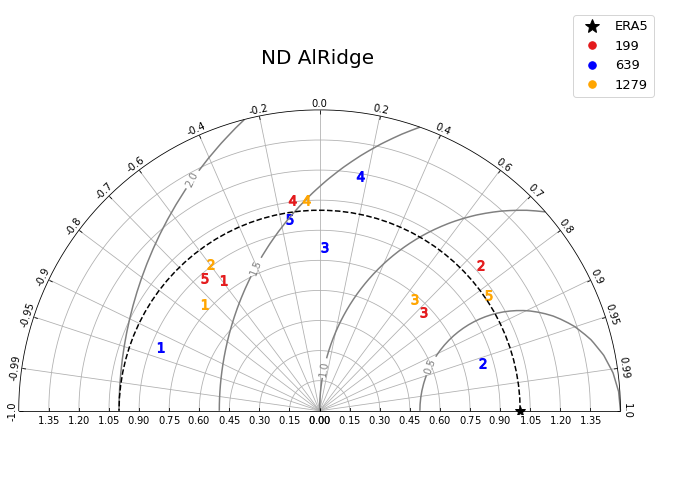

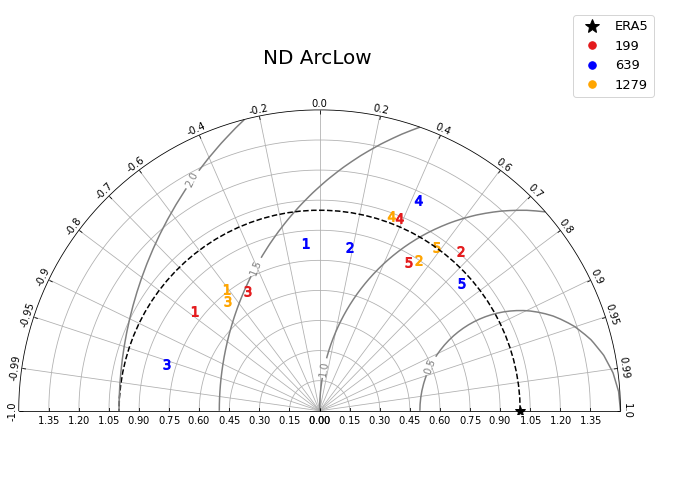

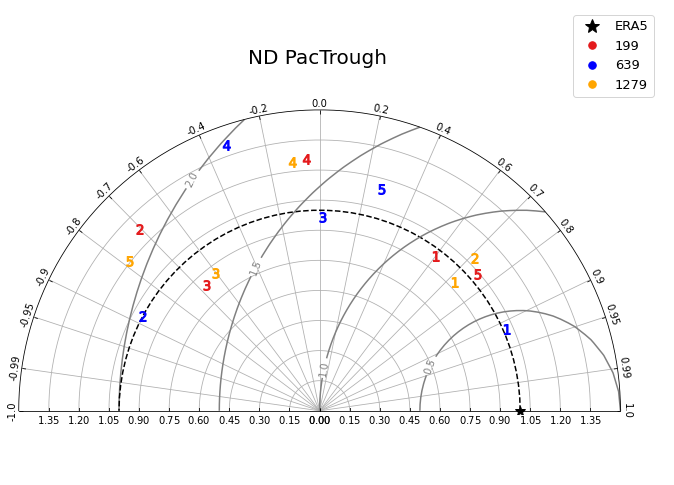

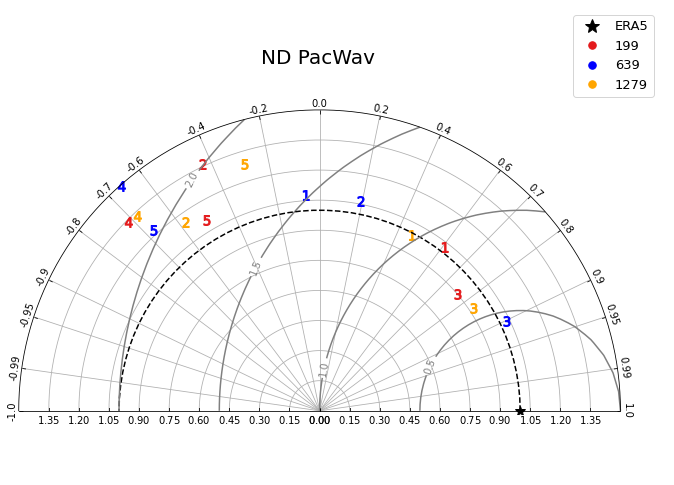

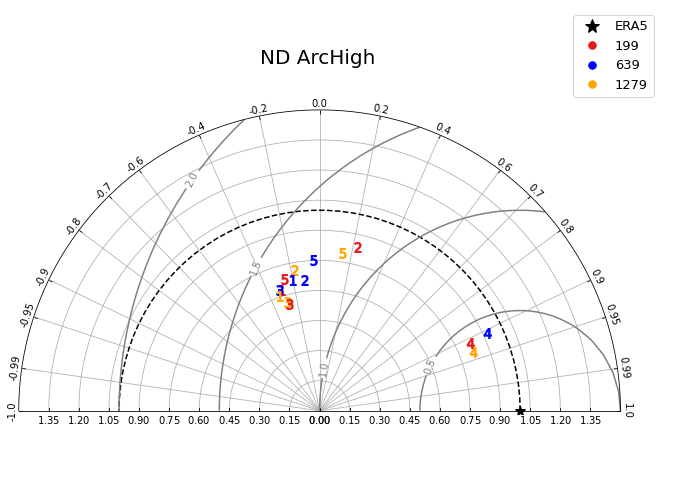

In [65]:
cluster_number = 0

if era_months == 'ND' and cluster_k==5:
    for regime in ['AlRidge', 'ArcLow', 'PacTrough', 'PacWav', 'ArcHigh']:
        
        # Create the figure
        fig = plt.figure(figsize=(11,8))

        # Title the figure
        fig.suptitle(era_months + ' ' + regime, size=20, x=.51, y=.87)
        
        # Create the taylor diagram for the season
        
        # Select the reference standard deviation and draw the appropriate curve
        dia = TaylorDiagram(refstd[cluster_number].values/refstd[cluster_number].values, fig=fig,
                            label='ERA5',extend=True)
        
        #dia.xrange=(min(refstd),max(refstd))
        #dia.set_xticks=np.arange(-100,100,1)
        
        # Add samples to Taylor diagram
        # Iterates through samples by regime
        # takes sample standard deviation, correlation coefficient, and model name for each sample of the season
        for i,(stddev,corrcoef,name) in enumerate(samples199[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc=colors[0], mec=colors[0], label=name)
        
        for i,(stddev,corrcoef,name) in enumerate(samples639[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc='blue', mec='blue', label=name)
            
        for i,(stddev,corrcoef,name) in enumerate(samples1279[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc='orange', mec='orange', label=name)
        
        cluster_number += 1
        
        # Add RMS contours, and label them
        contours = dia.add_contours(levels=5, colors='0.5') # 5 levels
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        
        era5_line = mlines.Line2D([], [], color='black', marker='*',ls='none',
                          markersize=15, label='ERA5')
        m199_line = mlines.Line2D([], [], color=colors[0], marker='.',ls='none',
                          markersize=15, label='199')
        m639_line = mlines.Line2D([], [], color='blue', marker='.',ls='none',
                          markersize=15, label='639')
        m1279_line = mlines.Line2D([], [], color='orange', marker='.',ls='none',
                          markersize=15, label='1279')
        
        
        fig.legend(handles = [era5_line,m199_line,m639_line,m1279_line],
           numpoints=1, prop=dict(size=13), loc=[.85,.8])
        
        # Add grid
        dia.add_grid()
        plt.savefig(f_pic + '.' + regime + '.png')

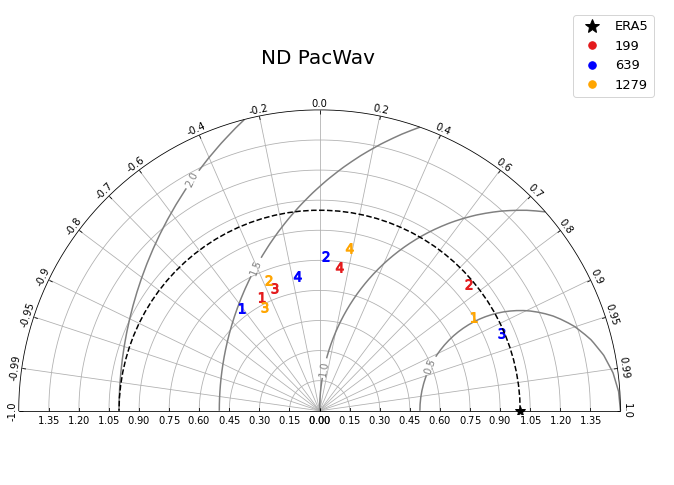

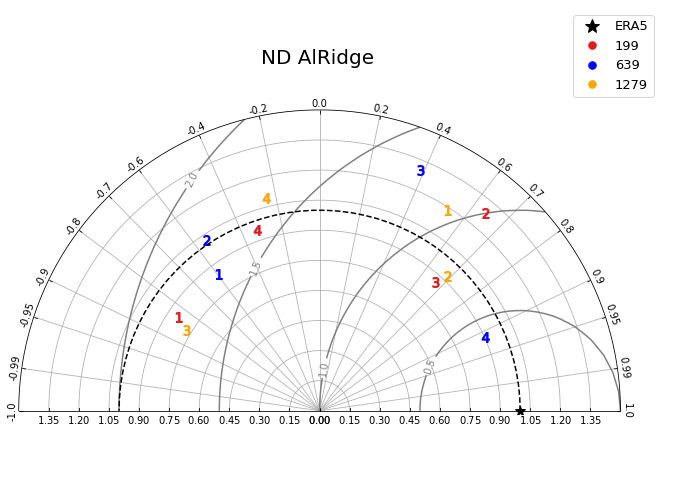

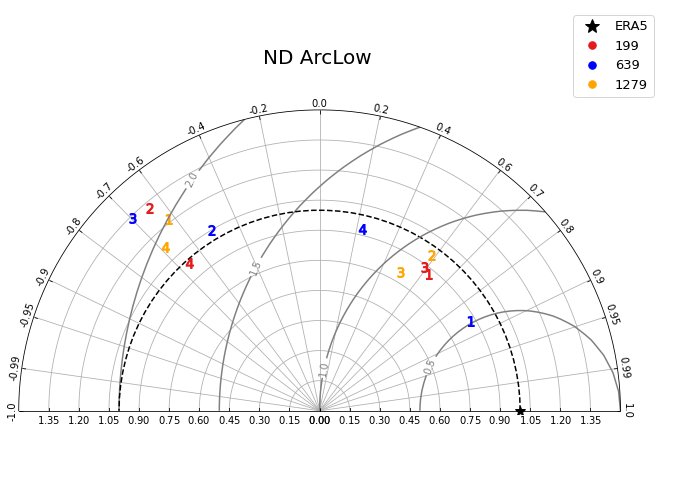

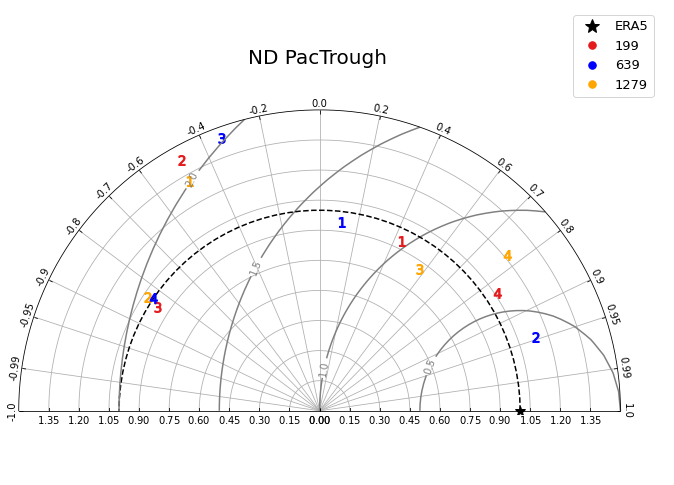

In [45]:
cluster_number = 0

if era_months == 'ND' and cluster_k==4:
    for regime in ['PacWav', 'AlRidge', 'ArcLow', 'PacTrough']:
        
        # Create the figure
        fig = plt.figure(figsize=(11,8))

        # Title the figure
        fig.suptitle(era_months + ' ' + regime, size=20, x=.51, y=.87)
        
        # Create the taylor diagram for the season
        
        # Select the reference standard deviation and draw the appropriate curve
        dia = TaylorDiagram(refstd[cluster_number].values/refstd[cluster_number].values, fig=fig,
                            label='ERA5',extend=True)
        
        #dia.xrange=(min(refstd),max(refstd))
        #dia.set_xticks=np.arange(-100,100,1)
        
        # Add samples to Taylor diagram
        # Iterates through samples by regime
        # takes sample standard deviation, correlation coefficient, and model name for each sample of the season
        for i,(stddev,corrcoef,name) in enumerate(samples199[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc=colors[0], mec=colors[0], label=name)
        
        for i,(stddev,corrcoef,name) in enumerate(samples639[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc='blue', mec='blue', label=name)
            
        for i,(stddev,corrcoef,name) in enumerate(samples1279[regime]):
            dia.add_sample(stddev/refstd[cluster_number].values, corrcoef,
                           marker='$%d$' % (i+1), ms=10, ls='',
                           #mfc='k', mec='k', # B&W
                           mfc='orange', mec='orange', label=name)
        
        cluster_number += 1
        
        # Add RMS contours, and label them
        contours = dia.add_contours(levels=5, colors='0.5') # 5 levels
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        
        era5_line = mlines.Line2D([], [], color='black', marker='*',ls='none',
                          markersize=15, label='ERA5')
        m199_line = mlines.Line2D([], [], color=colors[0], marker='.',ls='none',
                          markersize=15, label='199')
        m639_line = mlines.Line2D([], [], color='blue', marker='.',ls='none',
                          markersize=15, label='639')
        m1279_line = mlines.Line2D([], [], color='orange', marker='.',ls='none',
                          markersize=15, label='1279')
        
        
        fig.legend(handles = [era5_line,m199_line,m639_line,m1279_line],
           numpoints=1, prop=dict(size=13), loc=[.85,.8])
        
        # Add grid
        dia.add_grid()
        plt.savefig(f_pic + '.' + regime + '.png')